In [1]:
import pandas as pd
from pathlib import Path

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt


2025-08-18 08:08:21.597365: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755504501.610031       8 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755504501.614173       8 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-18 08:08:21.630251: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
train_csv = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/train.csv")
train_csv.head()


,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,1,0
1,Train_1,1,0,0,0
2,Train_2,0,0,1,0
3,Train_3,1,0,0,0
4,Train_4,0,0,1,0


In [5]:
test_csv = pd.read_csv("/kaggle/input/plant-pathology-2020-fgvc7/test.csv")
test_csv.head()


,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


(1365, 2048, 3)


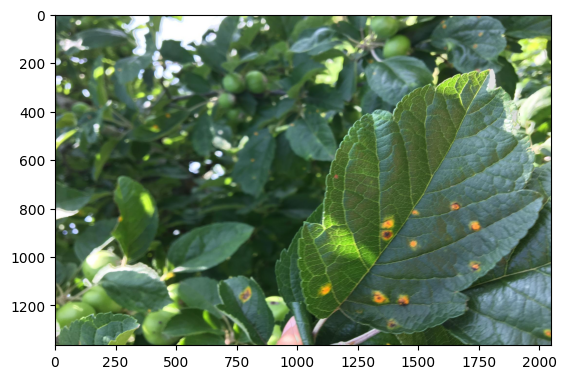

In [6]:
image = plt.imread('/kaggle/input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
plt.imshow(image)
print(image.shape)


In [7]:
def image_resize(img, size = (None, None), ratio=3):
    if size[0] is None:
        resize_ratio = ratio
        resize_height = int(img.shape[0]/resize_ratio)
        resize_width = int(img.shape[1]/resize_ratio)
        print(f"height: {resize_height}, width: {resize_width}")
    else:
        resize_height = size[0]
        resize_width = size[1]

    img_resize = tf.image.resize(img, [resize_height,resize_width]).numpy()
    img_resize = img_resize.astype(np.uint8)
    return(img_resize)


height: 455, width: 682
height: 341, width: 512


2025-08-18 08:08:27.955639: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


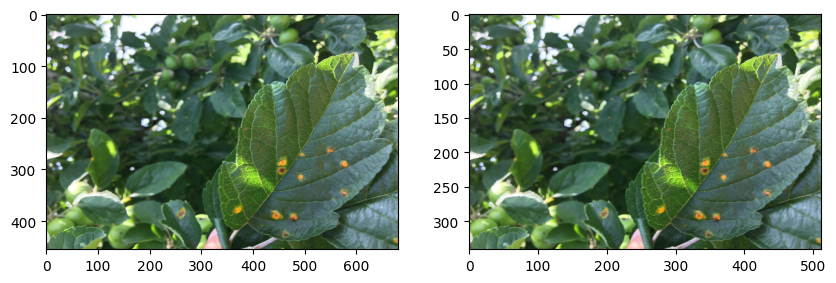

height: 273, width: 409
height: 227, width: 341


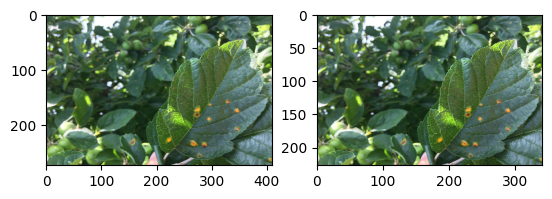

In [8]:
plt.figure(1, figsize=(10,10))
plt.subplot(221)
plt.imshow(image_resize(image, ratio = 3))

plt.subplot(222)
plt.imshow(image_resize(image, ratio = 4))
plt.show()

plt.subplot(223)
plt.imshow(image_resize(image, ratio = 5))

plt.subplot(224)
plt.imshow(image_resize(image, ratio = 6))
plt.show()


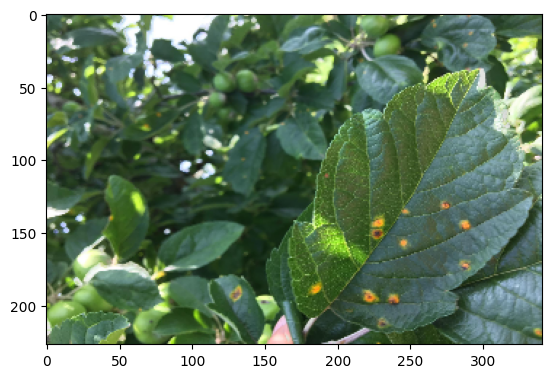

In [9]:
img_height = 227
img_width = 341
plt.imshow(image_resize(image, size=(img_height, img_width)))


In [10]:
train_resized = []

for img_id in train_csv['image_id'].to_list():
    image = plt.imread(f'/kaggle/input/plant-pathology-2020-fgvc7/images/{img_id}.jpg')
    train_resized.append(image_resize(image, (img_height, img_width)))

print(len(train_resized))

test_resized = []

for img_id in test_csv['image_id'].to_list():
    image = plt.imread(f'/kaggle/input/plant-pathology-2020-fgvc7/images/{img_id}.jpg')
    test_resized.append(image_resize(image, (img_height, img_width)))

print(len(test_resized))


1638
183


In [11]:
x_train = np.ndarray(shape = (len(train_resized), img_height, img_width, 3), dtype=np.float32)
x_test = np.ndarray(shape = (len(test_resized), img_height, img_width, 3), dtype=np.float32)

for i in range(len(train_resized)):
    x_train[i] = img_to_array(train_resized[i])

for i in range(len(test_resized)):
    x_test[i] = img_to_array(test_resized[i])

x_train = x_train/255
x_test = x_test/255

print(x_train.shape)
print(x_test.shape)


(1638, 227, 341, 3)
(183, 227, 341, 3)


In [12]:
y_train = train_csv.iloc[:,1:]
y_train.head()


,healthy,multiple_diseases,rust,scab
0,0,0,1,0
1,1,0,0,0
2,0,0,1,0
3,1,0,0,0
4,0,0,1,0


In [13]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.applications import InceptionResNetV2

resnet = InceptionResNetV2(weights='imagenet', include_top=False, pooling='avg')

model = Sequential()
model.add(resnet)
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.layers[0].trainable = False

model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_resnet_v2             │ (None, 1536)           │    54,336,736 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,541,988 (208.06 MB)

 Trainable params: 205,252 (801.77 KB)

 Non-trainable params: 54,336,736 (207.28 MB)

In [14]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics='accuracy')


ValueError: Expected `metrics` argument to be a list, tuple, or dict. Received instead: metrics=accuracy of type <class 'str'>

In [15]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size = 0.2)

print(train_x.shape)
print(train_y.shape)

print(val_x.shape)
print(val_y.shape)


(1310, 227, 341, 3)
(1310, 4)
(328, 227, 341, 3)
(328, 4)


In [16]:
datagen = ImageDataGenerator(rotation_range=25,
                             shear_range=.20,
                             zoom_range=.20,
                             width_shift_range=.20,
                             height_shift_range=.20,
                             horizontal_flip=True,
                             vertical_flip=True
                            )

#train_datagen = datagen.flow(rain, y_train, batch_size=42, seed=42)

batch_size = 24
datagen_without_aug = ImageDataGenerator()

train_datagen = datagen_without_aug.flow(train_x, train_y, batch_size=batch_size)

val_datagen = datagen_without_aug.flow(val_x, val_y, batch_size=batch_size)


In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit_generator(train_datagen, 
                              epochs=6,
                              steps_per_epoch=train_x.shape[0]//batch_size,
                              validation_data = val_datagen,
                              validation_steps = val_x.shape[0]//batch_size,
                              callbacks = [callback]
                   )


AttributeError: 'Sequential' object has no attribute 'fit_generator'

In [18]:
history_df = pd.DataFrame(history.history)
history_df.head()


NameError: name 'history' is not defined

In [19]:
plt.plot(history_df.index, history_df['accuracy'])
plt.plot(history_df.index, history_df['val_accuracy'])
plt.show()


NameError: name 'history_df' is not defined

In [20]:
plt.plot(history_df.index, history_df['loss'])
plt.plot(history_df.index, history_df['val_loss'])
plt.show()


NameError: name 'history_df' is not defined

In [21]:
y_preds = model.predict(x_test)


6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step


In [22]:
y_preds


array([[0.24156779, 0.2691098 , 0.38296452, 0.10635793],
       [0.30410638, 0.16865136, 0.4102555 , 0.11698686],
       [0.22635202, 0.2278425 , 0.4174734 , 0.12833211],
       [0.25509802, 0.2464642 , 0.36955568, 0.12888227],
       [0.3330127 , 0.19785611, 0.39439952, 0.07473157],
       [0.24358536, 0.21339159, 0.47768447, 0.06533851],
       [0.24844517, 0.2563314 , 0.321167  , 0.17405635],
       [0.27086863, 0.22699249, 0.3897897 , 0.11234923],
       [0.24687527, 0.2608227 , 0.32786852, 0.1644335 ],
       [0.2493633 , 0.24903241, 0.395274  , 0.10633022],
       [0.2356658 , 0.2881825 , 0.3755889 , 0.10056277],
       [0.27275005, 0.24892336, 0.36586657, 0.11245992],
       [0.2812444 , 0.2830705 , 0.30919364, 0.12649144],
       [0.25943032, 0.24355374, 0.39332953, 0.10368644],
       [0.28390685, 0.2485887 , 0.37773237, 0.08977199],
       [0.2830263 , 0.23812833, 0.3742221 , 0.1046232 ],
       [0.19843453, 0.22895747, 0.41676167, 0.15584639],
       [0.24606942, 0.31773183,

In [23]:
res = pd.DataFrame()
res['image_id'] = test_csv['image_id']
res['healthy'] = y_preds[:, 0]
res['multiple_diseases'] = y_preds[:, 1]
res['rust'] = y_preds[:, 2]
res['scab'] = y_preds[:, 3]
res.to_csv('submission.csv', index=False)
